In [44]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [45]:
img1 = cv2.imread('disparity-1.png')
img2 = cv2.imread('disparity-2.png')

In [46]:
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

In [47]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)

In [48]:
points1 = np.float32([kp1[m.queryIdx].pt for m in matches])
points2 = np.float32([kp2[m.trainIdx].pt for m in matches])

In [49]:
focal_length = 800  # Example focal length
center = (img1.shape[1] / 2, img1.shape[0] / 2)

K = np.array([[focal_length, 0, center[0]],
              [0, focal_length, center[1]],
              [0, 0, 1]])

In [50]:
E, mask = cv2.findEssentialMat(points1, points2, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)

In [51]:
points1, points2 = points1[mask.ravel() == 1], points2[mask.ravel() == 1]
_, R, t, mask_pose = cv2.recoverPose(E, points1, points2, K)


In [52]:
P1 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))  # Camera 1
P2 = K @ np.hstack((R, t))

In [53]:
points_4d_hom = cv2.triangulatePoints(P1, P2, points1.T, points2.T)

In [54]:
points_3d = points_4d_hom[:3] / points_4d_hom[3]

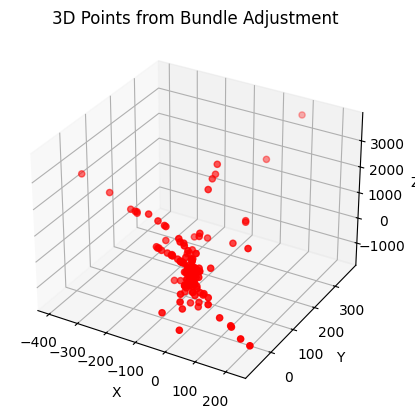

3D Points:
 [[ 7.08527374e+01  1.40977890e+02  1.25434888e+03]
 [-2.09770004e+02  3.38477936e+01  1.51321692e+03]
 [-2.09312424e+02  3.29298401e+01  1.57822498e+03]
 [-2.31122208e+02  3.33546524e+01  1.59807849e+03]
 [ 8.81846714e+00  5.01104164e+00  3.77165863e+02]
 [ 9.28774261e+00  4.42512894e+00  3.33113434e+02]
 [-3.42268372e+01  1.35534153e+01  1.01795245e+03]
 [-2.06202545e+01  1.18684797e+01  8.91770081e+02]
 [-3.77020657e-01 -2.47476622e-01 -4.20593567e+01]
 [-3.38543725e+00  7.83520937e-01  7.29364395e+01]
 [ 7.05112219e-01  2.51758486e-01  1.39387426e+01]
 [ 2.41469905e-01  4.61111426e-01  4.15047836e+01]
 [-2.55102997e+01  2.30862427e+01  2.20796432e+02]
 [-4.14503784e+01  1.62049622e+02  2.92931226e+03]
 [-5.44386005e+00  6.90880728e+00  6.70461853e+02]
 [ 4.58641472e+01  2.64497223e+02  2.63452734e+03]
 [ 3.09518886e+00 -6.02205396e-01  4.08490334e+01]
 [ 4.30367380e-01  7.23466277e-02  6.32785702e+00]
 [ 6.79147422e-01  2.08398104e-01  1.34184475e+01]
 [-2.16392231e+00  

In [55]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3d[0], points_3d[1], points_3d[2], c='r', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('3D Points from Bundle Adjustment')
plt.show()

# Print optimized 3D points
print("3D Points:\n", points_3d.T)